In [232]:
import os.path
from typing import List
from datetime import date, datetime, timedelta

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from datetime import date
from thefuzz import fuzz

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_colwidth = 160

from utils.configuration import settings
from utils.utils import *
from tft.api import *

In [233]:
API_KEY: str = settings.api_key
ASSETS_DIR: str = settings.assets_dir
SERVER = 'na1'  # euw1 na1 kr oc1
LEAGUE='challengers' # challengers grandmasters
MAX_COUNT: int = settings.max_count
LATEST_RELEASE = '12.12.450.4196' # '12.12.450.4196' Version 12.12.448.6653 12.11.446.9344 Version 12.13.453.3037 (Jul 11 2022/18:39:20) [PUBLIC] <Releases/12.13>
PATCH: date = date(2022, 7, 1)  # date(2022, 7, 1)
THREEDAY: datetime = (datetime.now() - timedelta(days=3)).strftime("%Y-%m-%d")

TARGETNAME = 'placement'

# Data Loading

In [234]:
# raw_df: DataFrame = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_matches.pickle'))
raw_df: DataFrame = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{THREEDAY}_matches.pickle'))

# Preprocessing

In [235]:
def impute(df) -> DataFrame:
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("object"):
        df[name] = df[name].fillna("None")
    return df

raw_df = impute(raw_df)

In [236]:
match_id_df: Series = raw_df['match_id']
X: DataFrame = raw_df.drop(['match_id'], axis=1)
y: Series = X.pop(TARGETNAME)
X.fillna('', inplace=True)
numeric_cols: List = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()
# traits level columns
traits_col: list = [s for s in numeric_cols if "Set7" in s]
# units level columns
units_col: list = [s for s in numeric_cols if "TFT7" in s]
# augments columns
augments_col: list[str] = ['augment0', 'augment1', 'augment2']
# units items columns
items_col = [s for s in categorical_cols if s not in augments_col]
df_unique = X.nunique().to_frame().reset_index()
df_unique.columns = ['Variable','DistinctCount']
unique_items_set = {y for col in items_col for y in X[col].unique().tolist()}
unique_augments_set = {y for col in augments_col for y in X[col].unique().tolist()}
X[f'items_count'] = X[items_col].apply(lambda row: sum(x != 'None' for x in row), axis=1)
X[f'traits_sum'] = X[traits_col].sum(axis=1)
X[f'units_sum'] = X[units_col].sum(axis=1)
X.iloc[X[f'units_sum'].idxmax()]

augment0           TFT7_Augment_MageConference
augment1          TFT6_Augment_TradeSectorPlus
augment2              TFT6_Augment_Meditation2
Set7_Assassin                              0.0
Set7_Astral                                1.0
                              ...             
TFT7_Zoe_item1                            None
TFT7_Zoe_item2                            None
items_count                                 11
traits_sum                                10.0
units_sum                                 27.0
Name: 3538, Length: 270, dtype: object

In [237]:
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()
X[numeric_cols] = X[numeric_cols].applymap(np.int64)
matches_df = X.copy()
matches_df[TARGETNAME] = y

In [238]:
def get_unit_items_ranking(df: matches_df, unit: str):
    # filter and melt the dataframe
    df = df.filter(regex=f'placement|{unit}_item0|{unit}_item1|{unit}_item2')
    df[f'unit'] = f'{unit}' # fill in current unit
    # join 3 items to 1 column
    df[f'{unit}_items'] = df[[f'{unit}_item0', f'{unit}_item1', f'{unit}_item2']].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)
    # sort items for unique combination
    df[f'{unit}_items'] = df[f'{unit}_items'].apply(lambda x: ', '.join(sorted(x.split(', '))))
    df = df.filter(regex=f'placement|{unit}_items|unit')
    m = df.melt(
        ['placement',f'unit'], value_name=f'{unit}_items_grp') #, value_vars=[f'{unit}_items', f'{unit}']
    # group and aggregate mean/median average_placement
    dct = {'value_count': (f'{unit}_items_grp', 'count'),
           'average_placement': ('placement', 'mean')}
    return m.groupby([f'unit', f'{unit}_items_grp'], as_index=False).agg(**dct).sort_values(by='average_placement')

In [239]:
get_unit_items_ranking(df = matches_df[:2], unit='TFT7_Zoe')

,unit,TFT7_Zoe_items_grp,value_count,average_placement
0,TFT7_Zoe,"None, None, None",2,5.0


In [240]:
# Get top5 
top5_items_list = []
for unit in units_col:
    df = get_unit_items_ranking(df = matches_df, unit=unit)
    df = df[df['value_count']>=12][:5] #Top 5 with counts >= 12
    top5_items_list.extend(df.values)

In [241]:
top5_items_list = pd.DataFrame(top5_items_list, columns=['unit', 'items',	'value_count',	'average_placement'])

In [242]:
top5_items_list.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_top5_items.csv'), index=False)

In [243]:
top5_items_list.groupby('unit').head(1)

,unit,items,value_count,average_placement
0,TFT7_Aatrox,"None, None, None",11796,4.502713
2,TFT7_Anivia,"ArchangelsStaff, None, SpearOfShojin",22,3.863636
7,TFT7_AoShin,"ArchangelsStaff, MageEmblemItem, SpearOfShojin",36,3.500000
12,TFT7_Ashe,"Chalice, None, ZekesHerald",12,3.333333
17,TFT7_AurelionSol,"None, None, None",11873,4.498779
18,TFT7_Bard,"None, None, RapidFireCannon",13,2.461538
23,TFT7_Braum,"None, None, Zephyr",14,4.285714
28,TFT7_Corki,"GuinsoosRageblade, ShimmerscaleDravensAxe, UnstableConcoction",16,3.937500
33,TFT7_Diana,"FrozenHeart, IonicSpark, RedBuff",19,3.000000
36,TFT7_DragonBlue,"Quicksilver, RevelEmblemItem, StatikkShiv",13,2.230769


# Load TFT asset

In [244]:
tft_assets = read_json(os.path.join(ASSETS_DIR, f'en_us.json'))

In [245]:
tft7_set = tft_assets['setData'][6]['champions'] #['apiName'] ['traits']['name'] #['champions'] #['champions'].name

In [246]:
champions_dict = {}

for champion in tft7_set:
    if champion["apiName"] not in champions_dict:
        champions_dict[champion["apiName"]] = []
    for trait in champion["traits"]:
        champions_dict[champion["apiName"]].append(trait)

In [247]:
champions_dict['TFT7_Olaf']

['Scalescorn', 'Bruiser', 'Warrior']

# Team Composition Ranking

In [248]:
def add_traits(units_str):
    # for units in units_str.split(', '):
    comp_array = []
    if len(units_str) == 0:
        return ''
    for unit in units_str.split(', '):
        traits_array = []
        for trait in champions_dict[unit]:
            traits_array.append(trait[:2]+trait[-1:]) # Add first 2 char for trait
        traits_str = '-'.join(traits_array) + f'-{unit}'
        comp_array.append(traits_str)

    # print(f'{"".join(comp_array)}')
    return ','.join(comp_array)

def get_unit_comp_ranking(df: DataFrame, add_trait=True):
    # filter and melt the dataframe
    df = df.filter(['placement']+units_col)
    # join units lvl > 0 to 1 column
    df['comp'] = df[units_col].apply(lambda row: ', '.join(row[row > 0].index.values.astype(str)), axis=1)
    if add_trait:
        df['comp'] = df['comp'].apply(add_traits)

    df['comp'] = df['comp'].str.replace('TFT7_','') # remove prefix .split('_',1).str[-1]
    df = df.filter(['placement', 'comp'])
    m = df.melt(
        ['placement'], value_name=f'comp_grp')
    # group and aggregate mean/median average_placement
    dct = {'value_count': (f'comp_grp', 'count'),
           'average_placement': ('placement', 'mean')}
    return m.groupby([f'comp_grp'], as_index=False).agg(**dct).sort_values(by='average_placement')

In [249]:
# Get top5 
comp_df = get_unit_comp_ranking(df = matches_df)

In [250]:
top5_comp_list = []
m = comp_df[comp_df['value_count']>=1] #[:5] #Top 5 with counts >= 12
top5_comp_list.extend(m.values)
comp_ranking_df = pd.DataFrame(top5_comp_list, columns=['comp', 'value_count', 'average_placement'])

In [251]:
comp_ranking_df #.groupby('comp').head(1)

,comp,value_count,average_placement
0,"Rag-Car-Hecarim,Jae-Shr-Neeko,Gud-Car-Sejuani,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah",1,1.0
1,"Jae-Drr-Swt-Ashe,Whs-Brr-Drn-DragonPurple,Jae-Shr-Gnar,Jae-Shr-Neeko,Whs-Mae-Brr-Sylas,Gud-Swt-Twitch,Mie-Drr-War-Yasuo",1,1.0
2,"Whs-Brr-Drn-DragonPurple,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Tet-Asn-Qiyana,Gud-Mae-Ryze,Rag-Brr-War-Shen,Whs-Mae-Brr-Sylas,She-Spf-Mae-Zoe",1,1.0
3,"Tet-Drn-AoShin,Gud-Myc-Bad-Bard,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Rag-Brr-War-Shen,Jae-Str-Soraka,Mie-Drr-War-Yasuo",1,1.0
4,"Gud-Myc-Bad-Bard,Rag-Car-Hecarim,Tet-Brr-Led-Ornn,Tet-Asn-Qiyana,Gud-Car-Sejuani,Rag-Brr-War-Shen,Jae-Str-Soraka,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah",1,1.0
...,...,...,...
6803,"Trr-Mae-Heimerdinger,Trr-Myc-Evr-Lulu,Rag-Car-Senna,Rag-Brr-War-Shen,-TrainerDragon,Trr-Car-Tristana",1,8.0
6804,"Trr-Mae-Heimerdinger,Trr-Myc-Evr-Lulu,Gud-Mae-Ryze,Gud-Car-Sejuani,Whs-Mae-Brr-Sylas,Gud-Asn-Talon,-TrainerDragon,Trr-Car-Tristana,Mie-Drr-War-Yasuo",1,8.0
6805,"Trr-Mae-Heimerdinger,Trr-Myc-Evr-Lulu,Asl-Mae-Myc-Nami,Tet-Brr-Led-Ornn,Gud-Mae-Ryze,Whs-Mae-Brr-Sylas,-TrainerDragon,Trr-Car-Tristana",1,8.0
6806,"Jae-Evr-Led-Anivia,Scn-Gun-Braum,Jae-Myc-Drn-DragonGreen,Jae-Shr-Neeko,Gud-Car-Sejuani,Jae-Str-Soraka,Mie-Drr-War-Yasuo",1,8.0


In [252]:
composition_ranking_df = comp_ranking_df.copy()

# Team composition Clustering

In [253]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('all-MiniLM-L6-v2')

2022-07-15 09:57:14,426 [INFO] Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2022-07-15 09:57:14,607 [INFO] Use pytorch device: cpu


In [254]:
corpus_sentences = list(comp_ranking_df['comp'])

corpus_embeddings = embedder.encode(corpus_sentences, batch_size=512, show_progress_bar=True, convert_to_tensor=True)
# Normalize the embeddings to unit length
# corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

Batches: 100%|██████████| 14/14 [01:39<00:00,  7.12s/it]


In [255]:
clustering_model = DBSCAN(eps=0.023, min_samples=1, metric='cosine', n_jobs=-1)
predict=clustering_model.fit_predict(corpus_embeddings)
comp_ranking_df['group'] = pd.Series(predict, index=comp_ranking_df.index)

In [256]:
comp_ranking_df.sort_values(by='group')

,comp,value_count,average_placement,group
0,"Rag-Car-Hecarim,Jae-Shr-Neeko,Gud-Car-Sejuani,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah",1,1.0,0
4845,"Rag-Car-Hecarim,Tet-Brr-Led-Ornn,Tet-Asn-Qiyana,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Gud-Swt-Twitch,Rag-Swt-Xayah",2,6.0,0
739,"Rag-Car-Hecarim,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Tet-Asn-Qiyana,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Gud-Asn-Talon,Rag-Swt-Xayah",1,1.0,0
715,"Rag-Car-Hecarim,Tet-Brr-Led-Ornn,Tet-Asn-Qiyana,Gud-Mae-Ryze,Rag-Brr-War-Shen,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah,Mie-Drr-War-Yasuo",1,1.0,0
694,"Rag-Car-Hecarim,Tet-Brr-Led-Ornn,Gud-Car-Sejuani,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah",2,1.0,0
...,...,...,...,...
6801,"Jae-Drr-Swt-Ashe,Asl-Brr-Illaoi,Tet-Drr-LeeSin,Tet-Brr-Led-Ornn,Gud-Swt-Twitch,Asl-Swt-Varus,Mie-Drr-War-Yasuo",1,8.0,2250
6803,"Trr-Mae-Heimerdinger,Trr-Myc-Evr-Lulu,Rag-Car-Senna,Rag-Brr-War-Shen,-TrainerDragon,Trr-Car-Tristana",1,8.0,2251
6804,"Trr-Mae-Heimerdinger,Trr-Myc-Evr-Lulu,Gud-Mae-Ryze,Gud-Car-Sejuani,Whs-Mae-Brr-Sylas,Gud-Asn-Talon,-TrainerDragon,Trr-Car-Tristana,Mie-Drr-War-Yasuo",1,8.0,2252
6806,"Jae-Evr-Led-Anivia,Scn-Gun-Braum,Jae-Myc-Drn-DragonGreen,Jae-Shr-Neeko,Gud-Car-Sejuani,Jae-Str-Soraka,Mie-Drr-War-Yasuo",1,8.0,2253


In [257]:
comp_ranking_df['grp_count'] = comp_ranking_df.groupby(['group'], as_index=False)['value_count'].transform('sum')
comp_ranking_df['grp_placement'] = comp_ranking_df.groupby(['group'], as_index=False)['average_placement'].transform('mean')

In [258]:
comp_ranking_df.sort_values(by='group')[:60]

,comp,value_count,average_placement,group,grp_count,grp_placement
0,"Rag-Car-Hecarim,Jae-Shr-Neeko,Gud-Car-Sejuani,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah",1,1.000000,0,977,4.713732
4845,"Rag-Car-Hecarim,Tet-Brr-Led-Ornn,Tet-Asn-Qiyana,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Gud-Swt-Twitch,Rag-Swt-Xayah",2,6.000000,0,977,4.713732
739,"Rag-Car-Hecarim,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Tet-Asn-Qiyana,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Gud-Asn-Talon,Rag-Swt-Xayah",1,1.000000,0,977,4.713732
715,"Rag-Car-Hecarim,Tet-Brr-Led-Ornn,Tet-Asn-Qiyana,Gud-Mae-Ryze,Rag-Brr-War-Shen,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah,Mie-Drr-War-Yasuo",1,1.000000,0,977,4.713732
694,"Rag-Car-Hecarim,Tet-Brr-Led-Ornn,Gud-Car-Sejuani,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah",2,1.000000,0,977,4.713732
690,"Rag-Car-Hecarim,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Tet-Asn-Qiyana,Gud-Car-Sejuani,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah",1,1.000000,0,977,4.713732
686,"Rag-Car-Hecarim,Tet-Brr-Led-Ornn,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah,Mie-Drr-War-Yasuo",1,1.000000,0,977,4.713732
4840,"Rag-Car-Hecarim,Tet-Drr-LeeSin,Mie-Car-Nunu,Tet-Brr-Led-Ornn,Gud-Car-Sejuani,Rag-Brr-War-Shen,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah",1,6.000000,0,977,4.713732
5066,"Rag-Car-Hecarim,Tet-Asn-Qiyana,Gud-Car-Sejuani,Rag-Brr-War-Shen,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah,Mie-Drr-War-Yasuo",6,6.166667,0,977,4.713732
5068,"Rag-Car-Hecarim,Tet-Drr-LeeSin,Tet-Brr-Led-Ornn,Gud-Car-Sejuani,Rag-Brr-War-Shen,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah",5,6.200000,0,977,4.713732


In [259]:
top5_comp_ranking_list = []
m = comp_ranking_df[comp_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
top5_comp_ranking_list.extend(m.values)
top_comp_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['comp', 'value_count', 'average_placement', 'group', 'grp_count', 'grp_placement'])

In [260]:
def remove_traits(units_str):
    """Remove units traits from text seperated by comma

    Args:
        units_str (str): traits-unit,traits-unit

    Returns:
        str: Units stripped of traits
    """    
    if len(units_str) == 0:
        return ''

    units_array = []
    for unit in units_str.split(','):
        units_array.append(unit.split('-')[-1])
    units = ', '.join(units_array)
    return units

top_comp_ranking_df['comp'] = top_comp_ranking_df['comp'].apply(remove_traits)


In [261]:
top_comp_ranking_df['mode'] = top_comp_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
top_comp_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,comp,value_count,average_placement,group,grp_count,grp_placement,mode
198,"Bard, DragonGold, Shen, Soraka, Talon, Xayah, Yasuo, Zoe",1,1.00,114,21,2.333333,"Bard, Braum, Corki, DragonGold, Kayn, Sona, Volibear, Yasuo, Zoe"
712,"Diana, DragonPurple, Ornn, Pyke, Qiyana, Sejuani, Talon, Yasuo",1,2.00,371,11,2.650000,"Diana, DragonPurple, Ornn, Pyke, Qiyana, Sejuani, Talon, Yasuo"
177,"Bard, DragonPurple, Ornn, Pyke, Qiyana, Sejuani, Talon, Twitch",1,1.00,97,82,2.806604,"Bard, DragonPurple, Ezreal, Hecarim, Ornn, Pyke, Talon, Twitch"
207,"Bard, Heimerdinger, Illaoi, Lulu, Nami, Sylas, Thresh, TrainerDragon, Twitch, Varus, Zoe",1,1.00,122,14,2.848485,"Bard, Heimerdinger, Illaoi, Lulu, Nami, Ornn, Sylas, TrainerDragon, Twitch, Varus"
319,"Corki, DragonBlue, Hecarim, Jinx, Nunu, Ornn, Sona, Yasuo",1,1.00,178,10,2.928571,"Corki, DragonBlue, Hecarim, Jinx, Nunu, Ornn, Sona, TahmKench"
...,...,...,...,...,...,...,...
99,"DragonPurple, Heimerdinger, Lulu, Nami, Ryze, Sona, Soraka, Sylas, TrainerDragon",1,1.00,62,54,5.857343,"DragonPurple, Heimerdinger, Illaoi, Lulu, Nami, Ryze, TrainerDragon"
2598,"Illaoi, Nami, Nidalee, Skarner, Sona, Varus, Vladimir",1,5.00,1237,21,6.137566,"Illaoi, Nami, Nidalee, Pyke, Skarner, Varus, Vladimir"
1562,"Ezreal, Illaoi, Ornn, Twitch, Varus, Xayah",4,3.25,770,26,6.210000,"Ezreal, Illaoi, LeeSin, Ornn, Twitch, Varus, Xayah"
2905,"Aatrox, DragonGold, Kayn, Swain, Twitch, Volibear, Xayah",1,6.00,1338,12,6.750000,"Aatrox, DragonGold, Hecarim, Kayn, Qiyana, Twitch, Xayah"


In [262]:
comp_ranking_df['comp'] = comp_ranking_df['comp'].apply(remove_traits)
comp_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_comp_ranking.csv'), index=False)

In [263]:
# from statistics import mode
# import jellyfish

# import pandas as pd

# df = pd.DataFrame({'Code': ['abc', 'abc', 'abc', 'abcc', 'abcc', 'zxc'],
#                    'Description': ['ABC String', 'abc string', 'ABC String and sth', 'abc sth else', 'zxc sth else', 'zxc zxc'],
#                 #    'Value': [10, 20, 30, 40, 100]
#                    })

# df_list = []
# for grp,df in df.groupby('Code'):
#     df['distance'] = df['Description'].apply(lambda x : fuzz.token_set_ratio(x, mode(df['Description'])))
#     # df['Description'] =  mode(df['Description'])
#     df_list.append(df[df['distance'] > 10])

# df = pd.concat(df_list)

In [264]:
# comp_ranking_df.groupby('comp')['comp'].apply(lambda x : fuzz.token_set_ratio(x, ','.join(units_col)))

In [265]:
# df_list = []
# for grp,df in comp_ranking_df.groupby('comp'):
#     df['distance'] = df['comp'].apply(lambda x : fuzz.token_set_ratio(x, 'Aatrox, DragonGold, Kayn, Shen, Twitch, Xayah, Zoe'))
#     # df['Description'] =  mode(df['Description'])
#     df_list.append(df[df['distance'] > 10])

# df = pd.concat(df_list)

In [266]:
composition_ranking_df

,comp,value_count,average_placement
0,"Rag-Car-Hecarim,Jae-Shr-Neeko,Gud-Car-Sejuani,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah",1,1.0
1,"Jae-Drr-Swt-Ashe,Whs-Brr-Drn-DragonPurple,Jae-Shr-Gnar,Jae-Shr-Neeko,Whs-Mae-Brr-Sylas,Gud-Swt-Twitch,Mie-Drr-War-Yasuo",1,1.0
2,"Whs-Brr-Drn-DragonPurple,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Tet-Asn-Qiyana,Gud-Mae-Ryze,Rag-Brr-War-Shen,Whs-Mae-Brr-Sylas,She-Spf-Mae-Zoe",1,1.0
3,"Tet-Drn-AoShin,Gud-Myc-Bad-Bard,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Rag-Brr-War-Shen,Jae-Str-Soraka,Mie-Drr-War-Yasuo",1,1.0
4,"Gud-Myc-Bad-Bard,Rag-Car-Hecarim,Tet-Brr-Led-Ornn,Tet-Asn-Qiyana,Gud-Car-Sejuani,Rag-Brr-War-Shen,Jae-Str-Soraka,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah",1,1.0
...,...,...,...
6803,"Trr-Mae-Heimerdinger,Trr-Myc-Evr-Lulu,Rag-Car-Senna,Rag-Brr-War-Shen,-TrainerDragon,Trr-Car-Tristana",1,8.0
6804,"Trr-Mae-Heimerdinger,Trr-Myc-Evr-Lulu,Gud-Mae-Ryze,Gud-Car-Sejuani,Whs-Mae-Brr-Sylas,Gud-Asn-Talon,-TrainerDragon,Trr-Car-Tristana,Mie-Drr-War-Yasuo",1,8.0
6805,"Trr-Mae-Heimerdinger,Trr-Myc-Evr-Lulu,Asl-Mae-Myc-Nami,Tet-Brr-Led-Ornn,Gud-Mae-Ryze,Whs-Mae-Brr-Sylas,-TrainerDragon,Trr-Car-Tristana",1,8.0
6806,"Jae-Evr-Led-Anivia,Scn-Gun-Braum,Jae-Myc-Drn-DragonGreen,Jae-Shr-Neeko,Gud-Car-Sejuani,Jae-Str-Soraka,Mie-Drr-War-Yasuo",1,8.0


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 28, cost: 11999.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 11741.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 11288.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1, cost: 11606.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 82, cost: 11897.0
Best run was number 3
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 738, cost: 9147.0
Run 1, iteration: 2/100, moves: 692, cost: 9147.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 761, cost: 10013.0
Init: initializing c

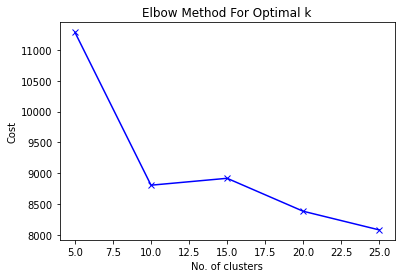

In [267]:
# Elbow curve to find optimal K
cost = []
K = range(5,30,5)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(composition_ranking_df)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [268]:
# Building the model with 3 clusters
kmode = KModes(n_clusters=10, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(composition_ranking_df)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 94, cost: 10438.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 319, cost: 10470.0
Run 2, iteration: 2/100, moves: 3, cost: 10470.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1701, cost: 9112.0
Run 3, iteration: 2/100, moves: 875, cost: 9112.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 9578.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 805, cost: 10298.0
Run 5, iteration: 2/100, moves: 1458, cost: 10298.0
Best run was number 3


array([7, 7, 7, ..., 1, 1, 1], dtype=uint16)

In [269]:
kmode_ranking_df = composition_ranking_df.copy()
kmode_ranking_df.insert(0, "group", clusters, True)

In [270]:
kmode_ranking_df

,group,comp,value_count,average_placement
0,7,"Rag-Car-Hecarim,Jae-Shr-Neeko,Gud-Car-Sejuani,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah",1,1.0
1,7,"Jae-Drr-Swt-Ashe,Whs-Brr-Drn-DragonPurple,Jae-Shr-Gnar,Jae-Shr-Neeko,Whs-Mae-Brr-Sylas,Gud-Swt-Twitch,Mie-Drr-War-Yasuo",1,1.0
2,7,"Whs-Brr-Drn-DragonPurple,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Tet-Asn-Qiyana,Gud-Mae-Ryze,Rag-Brr-War-Shen,Whs-Mae-Brr-Sylas,She-Spf-Mae-Zoe",1,1.0
3,7,"Tet-Drn-AoShin,Gud-Myc-Bad-Bard,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Rag-Brr-War-Shen,Jae-Str-Soraka,Mie-Drr-War-Yasuo",1,1.0
4,7,"Gud-Myc-Bad-Bard,Rag-Car-Hecarim,Tet-Brr-Led-Ornn,Tet-Asn-Qiyana,Gud-Car-Sejuani,Rag-Brr-War-Shen,Jae-Str-Soraka,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah",1,1.0
...,...,...,...,...
6803,1,"Trr-Mae-Heimerdinger,Trr-Myc-Evr-Lulu,Rag-Car-Senna,Rag-Brr-War-Shen,-TrainerDragon,Trr-Car-Tristana",1,8.0
6804,1,"Trr-Mae-Heimerdinger,Trr-Myc-Evr-Lulu,Gud-Mae-Ryze,Gud-Car-Sejuani,Whs-Mae-Brr-Sylas,Gud-Asn-Talon,-TrainerDragon,Trr-Car-Tristana,Mie-Drr-War-Yasuo",1,8.0
6805,1,"Trr-Mae-Heimerdinger,Trr-Myc-Evr-Lulu,Asl-Mae-Myc-Nami,Tet-Brr-Led-Ornn,Gud-Mae-Ryze,Whs-Mae-Brr-Sylas,-TrainerDragon,Trr-Car-Tristana",1,8.0
6806,1,"Jae-Evr-Led-Anivia,Scn-Gun-Braum,Jae-Myc-Drn-DragonGreen,Jae-Shr-Neeko,Gud-Car-Sejuani,Jae-Str-Soraka,Mie-Drr-War-Yasuo",1,8.0


In [271]:
kmode_ranking_df['grp_count'] = kmode_ranking_df.groupby(['group'], as_index=False)['value_count'].transform('sum')
kmode_ranking_df['grp_placement'] = kmode_ranking_df.groupby(['group'], as_index=False)['average_placement'].transform('mean')

In [272]:
top5_comp_ranking_list = []
m = comp_ranking_df[comp_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
top5_comp_ranking_list.extend(m.values)
top_comp_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['comp', 'value_count', 'average_placement', 'group', 'grp_count', 'grp_placement'])

In [273]:
kmode_ranking_df['comp'] = kmode_ranking_df['comp'].apply(remove_traits)
kmode_ranking_df['mode'] = kmode_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
kmode_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,group,comp,value_count,average_placement,grp_count,grp_placement,mode
0,7,"Hecarim, Neeko, Sejuani, Shen, Shyvana, Talon, Twitch, Xayah",1,1.0,731,1.000000,"Aatrox, Anivia, Bard, DragonGold, LeeSin, Ornn, Volibear, Yasuo"
842,2,"DragonBlue, Leona, Nunu, Sejuani, Thresh, Yasuo, Yone",2,2.0,835,2.000000,"Aatrox, Anivia, Ashe, Karma, Kayn, LeeSin, Ornn, Swain, Volibear"
906,9,"DragonPurple, Illaoi, Ornn, Pyke, Qiyana, Sejuani, Soraka, Sylas",1,2.0,1,2.000000,"DragonPurple, Illaoi, Ornn, Pyke, Qiyana, Sejuani, Soraka, Sylas"
726,0,"Illaoi, Skarner, Talon, Twitch, Varus",2,1.0,6208,3.773342,"Aatrox, Anivia, DragonGold, LeeSin, Ornn, Volibear, Yasuo, Zoe"
36,5,"Ashe, Elise, Gnar, Neeko, Sett, Shyvana, Swain, Xayah",2,1.0,858,4.257757,"Aatrox, Bard, DragonGold, Kayn, Soraka, Volibear, Yasuo, Zoe"
3408,6,"DragonPurple, Illaoi, Pyke, Shen, Skarner, Twitch, Varus",1,5.0,763,5.000000,"Aatrox, Bard, Braum, Diana, DragonGold, Kayn, Volibear"
4293,3,"Ashe, Bard, DragonGreen, Gnar, Lulu, Neeko, Talon",1,6.0,912,6.000000,"Aatrox, Anivia, Ashe, Kayn, LeeSin, Ornn, Soraka, Volibear, Yasuo"
4783,4,"Gnar, Neeko, Sett, Shyvana, Soraka, Swain, Yasuo",1,6.0,1,6.000000,"Gnar, Neeko, Sett, Shyvana, Soraka, Swain, Yasuo"
5152,8,"Anivia, Corki, DragonGreen, Jinx, Neeko, Sona, Soraka",1,7.0,767,7.000000,"Aatrox, Anivia, DragonGold, Kayn, Ornn, Volibear, Yasuo"
5171,1,,1,7.0,852,7.998791,


In [274]:
def get_unit_composition(df: matches_df):
    # filter and melt the dataframe
    df = df.filter(['placement']+units_col+traits_col)
    return df.sort_values(by='placement')

In [275]:
units_comp_df:DataFrame = get_unit_composition(matches_df)

In [276]:
units_comp_df

,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,TFT7_Diana,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
7292,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,3
1534,1,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,1,1,0,0
6565,1,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6574,1,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,1,1,0,0,0
6583,1,0,3,0,0,0,2,0,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,8,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2136,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7879,8,0,2,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
10492,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


## KMode

In [277]:
units_composition_df = units_comp_df.copy()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2399, cost: 146756.0
Run 1, iteration: 2/100, moves: 1359, cost: 145007.0
Run 1, iteration: 3/100, moves: 228, cost: 144946.0
Run 1, iteration: 4/100, moves: 1, cost: 144946.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 2577, cost: 142521.0
Run 2, iteration: 2/100, moves: 291, cost: 142514.0
Run 2, iteration: 3/100, moves: 28, cost: 142514.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1510, cost: 142593.0
Run 3, iteration: 2/100, moves: 622, cost: 142380.0
Run 3, iteration: 3/100, moves: 233, cost: 142364.0
Run 3, iteration: 4/100, moves: 25, cost: 142364.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 3585, cost: 135428.0
Run 4, iteration: 2/100, moves: 844, cost: 133947.0
Run

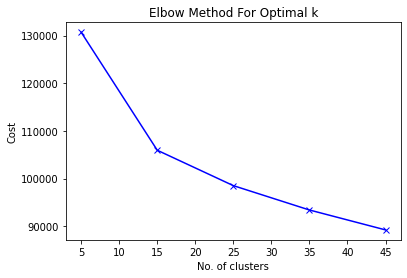

In [278]:
# Elbow curve to find optimal K
cost = []
K = range(5,50,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(units_composition_df)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [279]:
# Building the model with 3 clusters
kmode = KModes(n_clusters=25, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(units_composition_df)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4091, cost: 100432.0
Run 1, iteration: 2/100, moves: 1275, cost: 99650.0
Run 1, iteration: 3/100, moves: 587, cost: 99397.0
Run 1, iteration: 4/100, moves: 49, cost: 99397.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 4762, cost: 101583.0
Run 2, iteration: 2/100, moves: 2254, cost: 99417.0
Run 2, iteration: 3/100, moves: 538, cost: 99175.0
Run 2, iteration: 4/100, moves: 75, cost: 99149.0
Run 2, iteration: 5/100, moves: 14, cost: 99138.0
Run 2, iteration: 6/100, moves: 4, cost: 99138.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 3669, cost: 99736.0
Run 3, iteration: 2/100, moves: 1081, cost: 99357.0
Run 3, iteration: 3/100, moves: 201, cost: 99187.0
Run 3, iteration: 4/100, moves: 56, cost: 99187.0
Init: initializing centroids
Init: initializ

array([ 2, 17, 22, ..., 15,  4,  7], dtype=uint16)

In [280]:
kmode_ranking_df = units_composition_df.copy()
kmode_ranking_df.insert(0, "group", clusters, True)

In [281]:
kmode_ranking_df

,group,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
7292,2,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,3
1534,17,1,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,1,1,0,0
6565,22,1,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0
6574,4,1,0,0,0,0,0,2,0,0,...,0,0,0,0,0,1,1,0,0,0
6583,16,1,0,3,0,0,0,2,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,10,8,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2136,3,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7879,15,8,0,2,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
10492,4,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [282]:
def get_unit_composition_ranking(df: DataFrame, add_trait=True):
    # filter and melt the dataframe
    df = df.filter(['placement', 'group']+units_col)
    # join units lvl > 0 to 1 column
    df['comp'] = df[units_col].apply(lambda row: ', '.join(
        row[row > 0].index.values.astype(str)), axis=1)

    if add_trait:
        df['comp'] = df['comp'].apply(add_traits)

    df['comp'] = df['comp'].str.replace('TFT7_', '')
    df = df.filter(['placement', 'group', 'comp'])
    return df.sort_values(by='group')

In [283]:
kmode_ranking_df = get_unit_composition_ranking(kmode_ranking_df, add_trait=False)

In [284]:
kmode_ranking_df

,placement,group,comp
2043,6,0,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
910,3,0,"DragonPurple, Ornn, Pyke, Shen, Sylas, Talon, Yasuo"
6479,6,0,"DragonPurple, Ornn, Qiyana, Shen, Sylas, Talon, Yasuo"
7196,1,0,"DragonPurple, Jinx, Olaf, Ornn, Shen, Skarner, Sylas, TahmKench"
11923,2,0,"DragonPurple, Ornn, Pyke, Shen, Sylas, Talon, Thresh, Yasuo"
...,...,...,...
781,2,24,"Anivia, Ashe, DragonGreen, Gnar, Karma, Neeko, Soraka, Yasuo"
7296,7,24,"Anivia, DragonGreen, Gnar, Karma, Neeko, Soraka, Taric"
8446,5,24,"Anivia, DragonGreen, Gnar, Neeko, Ornn"
8791,4,24,"Ashe, DragonGreen, Gnar, Hecarim, Neeko, Sett, Swain"


In [285]:
kmode_ranking_df['grp_count'] = kmode_ranking_df.groupby(['group'], as_index=False)['group'].transform('count')
kmode_ranking_df['grp_placement'] = kmode_ranking_df.groupby(['group'], as_index=False)['placement'].transform('mean')

In [286]:
kmode_ranking_df

,placement,group,comp,grp_count,grp_placement
2043,6,0,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Talon",531,3.561205
910,3,0,"DragonPurple, Ornn, Pyke, Shen, Sylas, Talon, Yasuo",531,3.561205
6479,6,0,"DragonPurple, Ornn, Qiyana, Shen, Sylas, Talon, Yasuo",531,3.561205
7196,1,0,"DragonPurple, Jinx, Olaf, Ornn, Shen, Skarner, Sylas, TahmKench",531,3.561205
11923,2,0,"DragonPurple, Ornn, Pyke, Shen, Sylas, Talon, Thresh, Yasuo",531,3.561205
...,...,...,...,...,...
781,2,24,"Anivia, Ashe, DragonGreen, Gnar, Karma, Neeko, Soraka, Yasuo",411,4.863747
7296,7,24,"Anivia, DragonGreen, Gnar, Karma, Neeko, Soraka, Taric",411,4.863747
8446,5,24,"Anivia, DragonGreen, Gnar, Neeko, Ornn",411,4.863747
8791,4,24,"Ashe, DragonGreen, Gnar, Hecarim, Neeko, Sett, Swain",411,4.863747


In [287]:
top5_comp_ranking_list = []
m = kmode_ranking_df[kmode_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
top5_comp_ranking_list.extend(m.values)
top_kmode_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['placement', 'group', 'comp', 'grp_count', 'grp_placement'])

In [288]:
kmode_ranking_df['mode'] = kmode_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
kmode_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,placement,group,comp,grp_count,grp_placement,mode
1591,2,21,"Anivia, Bard, DragonGreen, Gnar, Neeko, Pyke, Soraka",556,3.420863,"Bard, DragonGreen, Elise, Gnar, Neeko, Nidalee, Soraka"
1896,8,17,"AoShin, Heimerdinger, Illaoi, Lulu, Nami, Ornn, Sylas, TrainerDragon",267,3.490637,"AoShin, Bard, Heimerdinger, Lulu, Ornn, Sylas, TrainerDragon, Zoe"
2043,6,0,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Talon",531,3.561205,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Thresh, Yasuo"
6694,1,18,"Bard, Corki, DragonPurple, Jinx, Lulu, Sona, TahmKench, TrainerDragon, Tristana",232,3.568966,"Bard, Corki, DragonPurple, Lulu, Ornn, Sona, TrainerDragon, Tristana"
2350,6,5,"Bard, Braum, DragonGold, Ornn, Qiyana, Talon, Yasuo",449,3.572383,"Aatrox, Bard, DragonGold, Kayn, Pyke, Volibear, Yasuo, Zoe"
2274,6,6,"Ashe, Ezreal, Illaoi, Ornn, Shen, Sylas, Twitch, Varus",282,3.666667,"DragonPurple, Ezreal, Illaoi, Ornn, Sylas, Twitch, Varus, Xayah"
9596,6,16,"Bard, DragonGreen, Gnar, Lulu, Neeko, Sona, Soraka",320,3.834375,"Anivia, Bard, DragonGreen, Gnar, Lulu, Neeko, Yasuo"
2490,3,13,"Braum, Diana, Olaf, Ornn, Qiyana, Shen, Sylas",107,3.971963,"Diana, Olaf, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
7850,3,14,"Anivia, Corki, Jinx, Lulu, Ornn, Sona, TahmKench, TrainerDragon, Tristana",152,3.973684,"Corki, DragonBlue, Jinx, Ornn, Sona, TahmKench, Yasuo"
6492,4,22,"DragonBlue, Hecarim, Lillia, Nunu, Sejuani, Yasuo, Yone",329,4.112462,"Bard, DragonBlue, Hecarim, Nunu, Sejuani, Yasuo, Yone"


## KMeans

In [289]:
units_composition_df = units_comp_df.copy()
X = units_composition_df.copy()
X.pop(TARGETNAME)

7292     1
1534     1
6565     1
6574     1
6583     1
        ..
1160     8
2136     8
7879     8
10492    8
1834     8
Name: placement, Length: 11928, dtype: int64

In [290]:
# normalization to improve the k-means result.
normalizer = Normalizer(copy=False)
kms = KMeans(n_clusters=num_clusters, init = "k-means++", n_init = 10, verbose=1)
kmeans = make_pipeline(normalizer, kms)

Initialization complete
Iteration 0, inertia 4734.482567484935.
Iteration 1, inertia 3298.8558029279975.
Iteration 2, inertia 3213.319695919526.
Iteration 3, inertia 3172.5719648820864.
Iteration 4, inertia 3141.0339490049064.
Iteration 5, inertia 3127.665970022832.
Iteration 6, inertia 3122.0787087461604.
Iteration 7, inertia 3119.2428753542313.
Iteration 8, inertia 3117.751079423012.
Iteration 9, inertia 3116.3074174976828.
Iteration 10, inertia 3115.1512416018495.
Iteration 11, inertia 3114.3275658578523.
Iteration 12, inertia 3113.2633060372054.
Iteration 13, inertia 3112.4173575223126.
Iteration 14, inertia 3111.7712412448723.
Iteration 15, inertia 3111.3469629196816.
Iteration 16, inertia 3111.0011493751813.
Iteration 17, inertia 3110.767187225507.
Iteration 18, inertia 3110.5897312710476.
Iteration 19, inertia 3110.4729959527026.
Iteration 20, inertia 3110.3789942903336.
Iteration 21, inertia 3110.301455271461.
Iteration 22, inertia 3110.226668555417.
Iteration 23, inertia 3110.

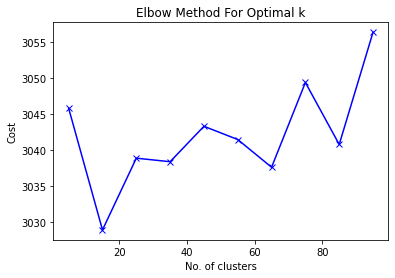

In [291]:
# Elbow curve to find optimal K
cost = []
K = range(5,100,10)
for num_clusters in list(K):
    kmeans.fit_predict(X)
    cost.append(kmeans[-1].inertia_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [292]:
# Building the model with 3 clusters
kms = KMeans(n_clusters=38, init = "k-means++", n_init = 10, verbose=1)
kmeans = make_pipeline(normalizer, kms)
clusters = kmeans.fit_predict(X)
clusters

Initialization complete
Iteration 0, inertia 4952.972310099396.
Iteration 1, inertia 3413.2802820171614.
Iteration 2, inertia 3308.3402300773414.
Iteration 3, inertia 3264.4783702387085.
Iteration 4, inertia 3238.768250323056.
Iteration 5, inertia 3225.6267874524365.
Iteration 6, inertia 3219.5991119103855.
Iteration 7, inertia 3215.4930620715677.
Iteration 8, inertia 3210.0850694987535.
Iteration 9, inertia 3203.7893644294786.
Iteration 10, inertia 3200.551662922482.
Iteration 11, inertia 3198.6475509355387.
Iteration 12, inertia 3197.1747724967545.
Iteration 13, inertia 3195.636650743952.
Iteration 14, inertia 3194.3385214717614.
Iteration 15, inertia 3192.2438521243316.
Iteration 16, inertia 3190.339224206963.
Iteration 17, inertia 3187.617116494294.
Iteration 18, inertia 3185.7668552920654.
Iteration 19, inertia 3184.273517406735.
Iteration 20, inertia 3182.8219773118108.
Iteration 21, inertia 3181.967369722168.
Iteration 22, inertia 3181.505991905521.
Iteration 23, inertia 3181.13

array([24,  3, 25, ..., 22,  2, 15])

In [293]:
kmeans_ranking_df = units_composition_df.copy()
kmeans_ranking_df.insert(0, "group", clusters, True)

In [294]:
kmeans_ranking_df

,group,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
7292,24,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,3
1534,3,1,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,1,1,0,0
6565,25,1,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0
6574,2,1,0,0,0,0,0,2,0,0,...,0,0,0,0,0,1,1,0,0,0
6583,35,1,0,3,0,0,0,2,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,3,8,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2136,26,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7879,22,8,0,2,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
10492,2,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [295]:
kmeans_ranking_df = get_unit_composition_ranking(kmeans_ranking_df, add_trait=False)

In [296]:
kmeans_ranking_df

,placement,group,comp
11193,5,0,"Anivia, DragonGreen, Elise, Gnar, Neeko, Nidalee"
3812,5,0,"Ashe, DragonGreen, Elise, Gnar, Neeko, Nidalee, Talon"
7735,3,0,"Anivia, Bard, DragonGreen, Elise, Gnar, Lulu, Neeko, Nidalee, Sylas"
11417,8,0,"Ashe, DragonGreen, Elise, Karma, Neeko, Nidalee, Swain"
10375,8,0,"DragonGreen, Elise, Gnar, Neeko, Nidalee, Taric, Thresh"
...,...,...,...
3919,7,37,"AoShin, Bard, Heimerdinger, Ornn, Sylas, Zoe"
792,7,37,"AoShin, LeeSin, Lulu, Shen, Sylas, Yasuo, Zoe"
3123,2,37,Bard
11782,5,37,"Bard, LeeSin, Lulu, Ornn, Ryze, Sona, Sylas, Zoe"


In [297]:
kmeans_ranking_df['grp_count'] = kmeans_ranking_df.groupby(['group'], as_index=False)['group'].transform('count')
kmeans_ranking_df['grp_placement'] = kmeans_ranking_df.groupby(['group'], as_index=False)['placement'].transform('mean')

In [298]:
kmeans_ranking_df['mode'] = kmeans_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
kmeans_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,placement,group,comp,grp_count,grp_placement,mode
1907,1,8,"Bard, DragonGreen, Gnar, Lulu, Neeko, Pyke, Soraka, Yasuo",286,3.615385,"Bard, DragonGreen, Gnar, Lulu, Neeko, Soraka, Yasuo"
2616,4,12,"Diana, DragonGold, Kayn, Ornn, Qiyana, Talon, Thresh",279,3.759857,"Diana, DragonPurple, Kayn, Ornn, Pyke, Qiyana, Talon"
6923,1,37,"AoShin, Bard, Lulu, Neeko, Ornn, Shen, Sona, Yasuo",200,3.875000,"AoShin, Bard, Gnar, Neeko, Ornn, Shen, Soraka, Yasuo"
6117,7,10,"DragonPurple, Illaoi, Shen, Sylas, Talon, Varus, Xayah",259,3.884170,"DragonPurple, Illaoi, Skarner, Sylas, Twitch, Varus"
2875,3,20,"AoShin, Bard, Heimerdinger, Lulu, Ornn, Sona, Sylas, TrainerDragon, Zoe",240,4.037500,"AoShin, Heimerdinger, Lulu, Nami, Ornn, Sylas, TrainerDragon, Zoe"
11193,5,0,"Anivia, DragonGreen, Elise, Gnar, Neeko, Nidalee",298,4.147651,"Bard, DragonGreen, Elise, Gnar, Neeko, Nidalee, Soraka"
3732,7,17,"Diana, DragonPurple, Elise, Ornn, Shen, Sylas, Talon",504,4.194444,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
6017,1,29,"Diana, Olaf, Ornn, Pyke, Qiyana, Shen, Sylas, Talon",127,4.204724,"Diana, Olaf, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
1381,4,30,"Illaoi, Lulu, Nami, Sylas, Twitch, Varus, Xayah, Zoe",252,4.210317,"Bard, Illaoi, Nami, Ornn, Qiyana, Talon, Twitch, Varus"
9472,3,18,"DragonGreen, Gnar, Neeko, Nunu, Pyke, Sejuani, Soraka, Talon",284,4.221831,"Bard, DragonGreen, Gnar, Neeko, Pyke, Soraka, Talon"


In [299]:
kmeans_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_kmeans_comp_ranking.csv'), index=False)

## DBSCAN

In [300]:
units_composition_df = units_comp_df.copy()
X = units_composition_df.copy()
X.pop(TARGETNAME)

7292     1
1534     1
6565     1
6574     1
6583     1
        ..
1160     8
2136     8
7879     8
10492    8
1834     8
Name: placement, Length: 11928, dtype: int64

In [301]:
units_composition_df.shape

(11928, 88)

In [302]:
# Building the model with 3 clusters
# normalization to improve the k-means result.
normalizer = Normalizer(copy=False)
dbs= DBSCAN(eps=0.37, metric='euclidean', min_samples=3, n_jobs=-1) #eps=0.053, metric='cosine'
dbscan = make_pipeline(normalizer, dbs)
clusters = dbscan.fit_predict(X)
clusters

array([-1,  0,  1, ...,  3,  2, -1], dtype=int64)

In [303]:
dbscan_ranking_df = units_composition_df.copy()
dbscan_ranking_df.insert(0, "group", clusters, True)

In [304]:
dbscan_ranking_df

,group,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
7292,-1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,3
1534,0,1,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,1,1,0,0
6565,1,1,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0
6574,2,1,0,0,0,0,0,2,0,0,...,0,0,0,0,0,1,1,0,0,0
6583,3,1,0,3,0,0,0,2,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,-1,8,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2136,-1,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7879,3,8,0,2,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
10492,2,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [305]:
dbscan_ranking_df = get_unit_composition_ranking(dbscan_ranking_df, add_trait=False)

In [306]:
dbscan_ranking_df

,placement,group,comp
7292,1,-1,"DragonPurple, Elise, Gnar, Sylas, Taric, Thresh"
2200,5,-1,"DragonGreen, Illaoi, Nami, Shen, Twitch, Varus"
1209,5,-1,"Corki, DragonGold, Jinx, Lulu, Shen, TrainerDragon, Tristana, Zoe"
10672,5,-1,"Bard, DragonGold, Hecarim, LeeSin, Lulu, Ornn, Shen, Sona, Xayah"
7581,5,-1,"DragonPurple, Illaoi, Ornn, Pyke, Qiyana, Shen, Talon"
...,...,...,...
1902,7,130,"Anivia, Corki, DragonGreen, Gnar, Neeko, Sona"
10226,8,131,"AoShin, DragonGold, DragonPurple, Ornn, Soraka"
6782,3,131,"AoShin, DragonGold, DragonPurple, Ornn, Yasuo"
535,7,131,"AoShin, DragonGold, DragonPurple, Kayn, Ornn"


In [307]:
dbscan_ranking_df['grp_count'] = dbscan_ranking_df.groupby(['group'], as_index=False)['group'].transform('count')
dbscan_ranking_df['grp_placement'] = dbscan_ranking_df.groupby(['group'], as_index=False)['placement'].transform('mean')
dbscan_ranking_df['mode'] = dbscan_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
dbscan_ranking_df.groupby(['group']).head(1).sort_values(by='grp_count', ascending=False)[:60]

,placement,group,comp,grp_count,grp_placement,mode
7621,4,0,"Heimerdinger, Illaoi, Lulu, Nami, Ryze, Sylas, TrainerDragon, Vladimir, Zoe",4031.0,4.612479,"Heimerdinger, Illaoi, Lulu, Nami, Ryze, Sylas, TrainerDragon, Vladimir"
6184,7,3,"Anivia, Ashe, DragonGreen, Gnar, Karma, Neeko",1336.0,4.179612,"Anivia, Bard, DragonGreen, Gnar, Lulu, Neeko, Yasuo"
10777,1,5,"Bard, DragonPurple, Ezreal, Illaoi, Ornn, Pyke, Sylas, Varus",1083.0,4.192982,"Bard, Illaoi, Nami, Ornn, Qiyana, Talon, Twitch, Varus"
6204,1,4,"DragonPurple, Ornn, Pyke, Qiyana, Sylas, Talon, Thresh, Yasuo",1030.0,4.173592,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Thresh"
3735,4,8,"DragonPurple, Elise, Gnar, Neeko, Pyke, Soraka, Sylas",844.0,4.000000,"DragonPurple, Elise, Gnar, Neeko, Pyke, Soraka, Sylas"
9810,5,1,"DragonBlue, Hecarim, Nunu, Ornn, Sejuani, Shen, Yasuo",609.0,4.415584,"Bard, DragonBlue, Hecarim, Nunu, Sejuani, Yasuo, Yone"
5753,1,6,"AoShin, DragonGold, DragonPurple, Ornn, Thresh, Yasuo",570.0,2.428571,"AoShin, DragonGold, DragonPurple, Ornn, Thresh"
8572,7,2,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah",462.0,4.342066,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah"
9927,3,12,"Anivia, Ashe, Karma, LeeSin, Ornn, Sett, Swain, Volibear",406.0,5.125000,"Anivia, Ashe, Karma, LeeSin, Ornn, Sett, Swain, Volibear"
7060,1,11,"DragonGreen, Elise, Gnar, Neeko, Nidalee, Soraka",391.0,4.000000,"Elise, Gnar, Neeko, Nidalee, Shyvana, Soraka, Swain"


In [308]:
dbscan_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_dbscan_comp_ranking.csv'), index=False)